/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s

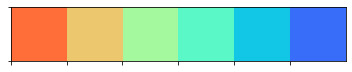

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from aggmap import AggMap, AggMapNet

from sklearn.model_selection import KFold, StratifiedKFold


import seaborn as sns
channel_list = [1, 3, 5, 7, 9, 11]
color = sns.color_palette("rainbow_r", len(channel_list)) #PiYG
sns.palplot(color)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #

In [3]:
_, w, h = x_train.shape
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)

In [4]:
mp = AggMap(x_train_df, metric='correlation', by_scipy=True)

2021-10-13 10:28:17,088 - INFO - [bidd-aggmap] - Calculating distance ...


100%|##########| 784/784 [00:02<00:00, 385.87it/s]


In [5]:
n_splits = 5 #5-fold reapeat 5 times
for c in channel_list: 
    run_all = []
    for repeat_seed in [8]: #3 repeats random seeds

        outer = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = repeat_seed)
        outer_idx = list(outer.split(x_train_df, pd.Series(y_train)))

        mp = mp.fit(cluster_channels = c, verbose = 0)
        
        X = mp.batch_transform(x_train_df.values)
        Y = pd.get_dummies(pd.Series(y_train)).values

        for i, idx in enumerate(outer_idx):
            
            train_idx, valid_idx = idx
            fold_num = "fold_%s" % str(i+1).zfill(2) 
            
            validY = Y[valid_idx]
            validX = X[valid_idx]

            trainX = X[train_idx]
            trainY = Y[train_idx]

            print("\n input train and test X shape is %s, %s " % (trainX.shape,  validX.shape))
            clf = AggMapNet.MultiClassEstimator(epochs = 100,  batch_size = 64, verbose=0,
                                                conv1_kernel_size = 3, dense_layers = [128, 64], 
                                                lr = 0.0001,  gpuid=1)
            clf.fit(trainX, trainY, X_valid = validX, y_valid = validY)

            history = clf.history
            history['fold'] = fold_num
            history['c'] = c
            history['repeat_seed'] = repeat_seed
            
            run_all.append(history)
        
    pd.DataFrame(run_all).to_csv('C=%s.csv' % c)

2021-10-13 22:29:43,082 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-10-13 22:29:49,900 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-10-13 22:29:50,543 - INFO - [bidd-aggmap] - Finished


100%|##########| 60000/60000 [00:48<00:00, 1234.02it/s]



 input train and test X shape is (48000, 28, 28, 41), (12000, 28, 28, 41) 
